# Clustering

## I. Imports & functions

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tslearn.metrics import dtw
from tslearn.datasets import CachedDatasets
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape, TimeSeriesKMeans
import skfuzzy as fuzz
import matrixprofile as mp
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score
from fcmeans import FCM

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [2]:
data_flat = pd.read_csv('data/data_flat.csv')
data_flat.head()

,countrycode,country,co2_emission_1990,co2_emission_1991,co2_emission_1992,co2_emission_1993,co2_emission_1994,co2_emission_1995,co2_emission_1996,co2_emission_1997,co2_emission_1998,co2_emission_1999,co2_emission_2000,co2_emission_2001,co2_emission_2002,co2_emission_2003,co2_emission_2004,co2_emission_2005,co2_emission_2006,co2_emission_2007,co2_emission_2008,co2_emission_2009,co2_emission_2010,co2_emission_2011,co2_emission_2012,co2_emission_2013,co2_emission_2014,co2_emission_2015,co2_emission_2016,co2_emission_2017,co2_emission_2018,co2_emission_2019,csh_c_1990,csh_c_1991,csh_c_1992,csh_c_1993,csh_c_1994,csh_c_1995,csh_c_1996,csh_c_1997,csh_c_1998,csh_c_1999,csh_c_2000,csh_c_2001,csh_c_2002,csh_c_2003,csh_c_2004,csh_c_2005,csh_c_2006,csh_c_2007,csh_c_2008,csh_c_2009,csh_c_2010,csh_c_2011,csh_c_2012,csh_c_2013,csh_c_2014,csh_c_2015,csh_c_2016,csh_c_2017,csh_c_2018,csh_c_2019,csh_g_1990,csh_g_1991,csh_g_1992,csh_g_1993,csh_g_1994,csh_g_1995,csh_g_1996,csh_g_1997,csh_g_1998,csh_g_1999,csh_g_2000,csh_g_2001,csh_g_2002,csh_g_2003,csh_g_2004,csh_g_2005,csh_g_2006,csh_g_2007,csh_g_2008,csh_g_2009,csh_g_2010,csh_g_2011,csh_g_2012,csh_g_2013,csh_g_2014,csh_g_2015,csh_g_2016,csh_g_2017,csh_g_2018,csh_g_2019,csh_i_1990,csh_i_1991,csh_i_1992,csh_i_1993,csh_i_1994,csh_i_1995,csh_i_1996,csh_i_1997,csh_i_1998,csh_i_1999,csh_i_2000,csh_i_2001,csh_i_2002,csh_i_2003,csh_i_2004,csh_i_2005,csh_i_2006,csh_i_2007,csh_i_2008,csh_i_2009,csh_i_2010,csh_i_2011,csh_i_2012,csh_i_2013,csh_i_2014,csh_i_2015,csh_i_2016,csh_i_2017,csh_i_2018,csh_i_2019,csh_m_1990,csh_m_1991,csh_m_1992,csh_m_1993,csh_m_1994,csh_m_1995,csh_m_1996,csh_m_1997,csh_m_1998,csh_m_1999,csh_m_2000,csh_m_2001,csh_m_2002,csh_m_2003,csh_m_2004,csh_m_2005,csh_m_2006,csh_m_2007,csh_m_2008,csh_m_2009,csh_m_2010,csh_m_2011,csh_m_2012,csh_m_2013,csh_m_2014,csh_m_2015,csh_m_2016,csh_m_2017,csh_m_2018,csh_m_2019,csh_r_1990,csh_r_1991,csh_r_1992,csh_r_1993,csh_r_1994,csh_r_1995,csh_r_1996,csh_r_1997,csh_r_1998,csh_r_1999,csh_r_2000,csh_r_2001,csh_r_2002,csh_r_2003,csh_r_2004,csh_r_2005,csh_r_2006,csh_r_2007,csh_r_2008,csh_r_2009,csh_r_2010,csh_r_2011,csh_r_2012,csh_r_2013,csh_r_2014,csh_r_2015,csh_r_2016,csh_r_2017,csh_r_2018,csh_r_2019,csh_x_1990,csh_x_1991,csh_x_1992,csh_x_1993,csh_x_1994,csh_x_1995,csh_x_1996,csh_x_1997,csh_x_1998,csh_x_1999,csh_x_2000,csh_x_2001,csh_x_2002,csh_x_2003,csh_x_2004,csh_x_2005,csh_x_2006,csh_x_2007,csh_x_2008,csh_x_2009,csh_x_2010,csh_x_2011,csh_x_2012,csh_x_2013,csh_x_2014,csh_x_2015,csh_x_2016,csh_x_2017,csh_x_2018,csh_x_2019,delta_1990,delta_1991,delta_1992,delta_1993,delta_1994,delta_1995,delta_1996,delta_1997,delta_1998,delta_1999,delta_2000,delta_2001,delta_2002,delta_2003,delta_2004,delta_2005,delta_2006,delta_2007,delta_2008,delta_2009,delta_2010,delta_2011,delta_2012,delta_2013,delta_2014,delta_2015,delta_2016,delta_2017,delta_2018,delta_2019,emp_percent_1990,emp_percent_1991,emp_percent_1992,emp_percent_1993,emp_percent_1994,emp_percent_1995,emp_percent_1996,emp_percent_1997,emp_percent_1998,emp_percent_1999,emp_percent_2000,emp_percent_2001,emp_percent_2002,emp_percent_2003,emp_percent_2004,emp_percent_2005,emp_percent_2006,emp_percent_2007,emp_percent_2008,emp_percent_2009,emp_percent_2010,emp_percent_2011,emp_percent_2012,emp_percent_2013,emp_percent_2014,emp_percent_2015,emp_percent_2016,emp_percent_2017,emp_percent_2018,emp_percent_2019,employment_agro_1990,employment_agro_1991,employment_agro_1992,employment_agro_1993,employment_agro_1994,employment_agro_1995,employment_agro_1996,employment_agro_1997,employment_agro_1998,employment_agro_1999,employment_agro_2000,employment_agro_2001,employment_agro_2002,employment_agro_2003,employment_agro_2004,employment_agro_2005,employment_agro_2006,employment_agro_2007,employment_agro_2008,employment_agro_2009,employment_agro_2010,employment_agro_2011,employment_agro_2012,employment_agro_2013,employment_agro_2014,employment_agro_2015,employment_agro_2016,employment_agro_2017,employment_agro_2018,employment

In [4]:
data = pd.read_csv('data/data.csv')
data.head()

,countrycode,country,year,pop,rgdpna,delta,xr,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,rgdpna_per_cap,emp_percent,co2_emission,employment_agro,employment_industry,employment_services,export,import,inflation,net_migration,population_15_64,population_above_65,population_under_14,unemployment,urban_population,hdi
0,ALB,Albania,1990,0.020266,0.001841,0.151999,0.088576,0.475201,0.093659,0.317663,0.018863,0.954592,0.158237,0.021368,0.466870,0.040463,0.995473,0.023282,0.040798,0.035778,0.234066,0.026795,0.093730,0.045050,0.012636,0.995734,0.428295,0.008616,0.051255
1,ALB,Albania,1991,0.020158,0.001765,0.146769,0.122181,0.484793,0.087354,0.330491,0.018106,0.947753,0.157691,0.020529,0.450952,0.035597,0.993862,0.023786,0.042039,0.035841,0.258771,0.030538,0.097011,0.038567,0.017593,0.995729,0.429421,0.012412,0.042410
2,ALB,Albania,1992,0.020010,0.001737,0.140639,0.167289,0.487556,0.087580,0.339263,0.016650,0.942814,0.164122,0.020431,0.434157,0.030689,0.990899,0.024757,0.044296,0.036417,0.272822,0.032010,0.102411,0.031683,0.024157,0.994572,0.430850,0.017598,0.036869
3,ALB,Albania,1993,0.019828,0.001777,0.134270,0.221561,0.479223,0.095106,0.348672,0.014622,0.940917,0.179091,0.021354,0.419071,0.026408,0.986223,0.026156,0.047938,0.036917,0.269351,0.030130,0.110334,0.026117,0.032217,0.991197,0.432400,0.024219,0.037571
4,ALB,Albania,1994,0.019638,0.001881,0.128552,0.279895,0.459342,0.107618,0.369705,0.012502,0.941699,0.198760,0.023224,0.407361,0.023288,0.979889,0.027685,0.053085,0.036798,0.249430,0.025328,0.120462,0.024476,0.041217,0.984334,0.433774,0.032028,0.045982


### KMeans

In [11]:
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(data_flat.iloc[:, 2:])

In [12]:
fig = px.choropleth(data_flat, locations = 'countrycode', color = y_kmeans, projection='conic conformal')
fig.update_geos(
    lataxis_range=[35, 75], lonaxis_range=[-15, 45]
)
fig.show()

In [13]:
k_max = 10
inertias = []
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(data_flat.iloc[:, 2:])
    inertias.append(kmeans.inertia_)

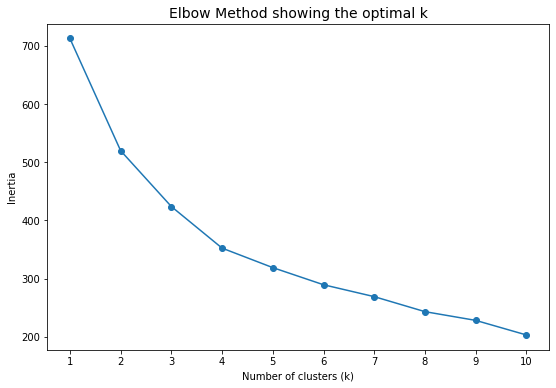

In [14]:
elbow = plt.plot(list(range(1, len(inertias) + 1)), inertias, '-o')
plt.title('Elbow Method showing the optimal k', size=14)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(list(range(1, len(inertias) + 1)));

In [17]:
k_max = 15
silhouette = []
for k in range(2, k_max+1):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    silhouette.append(silhouette_score(data_flat.iloc[:, 2:], kmeans.fit_predict(data_flat.iloc[:, 2:])))

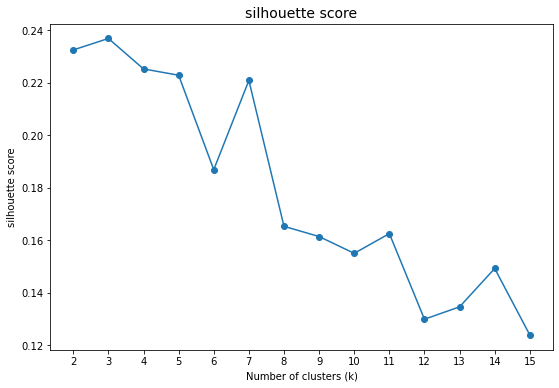

In [18]:
elbow = plt.plot(list(range(2, len(silhouette)+2 )), silhouette, '-o')
plt.title('silhouette score', size=14)
plt.xlabel('Number of clusters (k)')
plt.ylabel('silhouette score')
plt.xticks(list(range(2, len(silhouette)+2 )));

## AgglomerativeClustering

In [19]:
agglomerative = AgglomerativeClustering(linkage = 'ward', n_clusters = 4)
y_agg = agglomerative.fit_predict(data_flat.iloc[:, 2:])

In [20]:
fig = px.choropleth(data_flat, locations = 'countrycode', color = y_agg, projection='conic conformal')
fig.update_geos(
    lataxis_range=[35, 75], lonaxis_range=[-15, 45]
)
fig.show()

## Fuzzy C-Means

In [22]:
fcm = FCM(n_clusters=4)
fcm.fit(np.array(data_flat.iloc[:, 2:]))
y_fcm = fcm.predict(np.array(data_flat.iloc[:, 2:]))

In [23]:
#help(FCM)

In [27]:
fig = px.choropleth(data_flat, locations = 'countrycode', color = y_fcm, projection='conic conformal')
fig.update_geos(
    lataxis_range=[35, 75], lonaxis_range=[-15, 45]
)
fig.show()

In [28]:
y_fcm

array([1, 2, 2, 0, 1, 0, 2, 0, 3, 2, 3, 0, 2, 3, 3, 0, 1, 0, 2, 2, 3, 0,
       2, 0, 1, 1, 2, 1, 2, 2, 1, 0, 1, 3, 1, 0, 0, 2, 1], dtype=int64)

In [29]:
a, b, c, d, e, f, g = fuzz.cluster.cmeans(data.iloc[:, 2:], 3, 2, error=0.005, maxiter=1000)


In [30]:
g

0.9999999437772605

## DBSCAN

In [31]:
# tuning hyperparameters
min_grid = [x for x in range(2, 39, 1)]
eps_grid = np.arange(0.1, 5, 0.1)
best_params = {}
for m in min_grid:
    for e in eps_grid:
        dbscan = DBSCAN(eps = e, min_samples = m).fit(data_flat.iloc[:, 2:])
        labels = dbscan.labels_

        if len(set(labels)) > 1:
            cal_score = calinski_harabasz_score(data_flat.iloc[:, 2:], labels)

            if cal_score > 0:
                best_params[str(m) + " - " + str(e)] = cal_score
                
max_key = max(best_params, key = best_params.get)
print("parameter values are: ", max_key)
print("maximum calinski-harabasz score value is: ", best_params[max_key])
dbs = DBSCAN(min_samples=22, eps=4.6)
y_dbs = dbs.fit_predict(data_flat.iloc[:, 2:])

parameter values are:  22 - 4.6
maximum calinski-harabasz score value is:  5.9625463288734855


In [32]:
fig = px.choropleth(data_flat, locations = 'countrycode', color = y_dbs, projection='conic conformal')
fig.update_geos(
    lataxis_range=[35, 75], lonaxis_range=[-15, 45]
)
fig.show()

In [36]:
# from dtaidistance import dtw
# df = data.drop(['countrycode', 'country'], axis = 1)
# df = dtw.distance_matrix_fast(df)
# df.head()

# dtw(data['hdi'], data['co2_emission'])
# tslearn.utils.to_time_series_dataset(data.drop(['countrycode', 'country'], axis = 1)).shape

df = data.drop('year', axis=1).groupby(['countrycode', 'country']).agg(list)
all = np.empty(shape=(39,26,30))
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        all[i][j] = np.array(df.iloc[i,j])

# X = random_walks(n_ts=39, sz=30, d=26)
all = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(all)
# ks = KShape(n_clusters=4, n_init=1, random_state=0).fit(all)
ks = TimeSeriesKMeans(n_clusters=4).fit(all)
ks.cluster_centers_
ks.labels_

fig = px.choropleth(data_flat, locations = 'countrycode', color = ks.labels_, projection='conic conformal')
fig.update_geos(
    lataxis_range=[35, 75], lonaxis_range=[-15, 45]
)
fig.show()

# (39, 27, 30)
# [Albania[hdi[1, 2, 3, 4,5, 6 ,7 .. ,30], co2[1,2,3, ..., 4]]]

# np.stack(np.array(df))
# tslearn.utils.to_time_series_dataset(df)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# X_train[0]



In [37]:
agglomerative = AgglomerativeClustering(linkage = 'ward', n_clusters = 4)
y_agg = agglomerative.fit_predict(all)

ValueError: Found array with dim 3. AgglomerativeClustering expected <= 2.

In [38]:
fcm = FCM(n_clusters=4)
fcm.fit(all)
y_fcm = fcm.predict(all)

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

In [40]:
fuzz.cluster.cmeans(data, 3, 2, error=0.005, maxiter=1000)

TypeError: can't multiply sequence by non-int of type 'float'